## Tic Tac Toe Environment

The 'TicTacToeEnv' class is used to set up the environment to train the agent to effectively choose best moves against a computer opponent. The computer opponent makes choices entirely randomly, but the hope is that with enough moves the agent will learn the appropriate policy. The environment is set up for the agent to always make the first move. The board is set up with the following states:
```
 0 | 1 | 2
 - - - - -
 3 | 4 | 5
 - - - - -
 6 | 7 | 8
 ```
 The agent moves are marked by 'x' and computer moves are marked by 'o'. The state-value function is set up as a defaultdict with keys representing states as state-availability pairs. The values are represented as available states - action pairs. An example of this is:
 ```
 a | a | a
 - - - - -
 o | x | a
 - - - - -
 a | a | a
 ```
 'a' means the state is available. The state would then be: {0:'a', 1:'a', 2:'a', 3:'o', 4:'x', 5:'a', 6:'a', 7:'a', 8:'a'} and the value would be: {0: N1, 1: N2, 2: N3, 5: N4, 6: N5, 7: N6, 8: N7}. The actions to place a mark into states 3 and 4 are missing because those states are occupied. The Ns represent the action-values that will be adjusted with SARSA or Q_learning algorithms. This is represented in the action-value dictionary as:
 ```python
Q["{0:'a', 1:'a', 2:'a', 3:'o', 4:'x', 5:'a', 6:'a', 7:'a', 8:'a'}"] = {0: N1, 1: N2, 2: N3, 5: N4, 6: N5, 7: N6, 8: N7}
````
As the agent encounters new states these states are added into the dictionary to be modified when encountered later. The rewards are setup to yield a reward of +5 for every win, -1 for every move, and -10 for every loss. 
For the purposes of demonstration there is a SARSA-based python Tic Tac Toe game provided. Make sure the *tic_tac_toe_game.py* and the *Q_sarsa.json* files are in the same directory. Use <code>python tic_tac_toe_game.py</code> in console to play and follow instructions. The action-value dictionary is loaded into the script via the *Q_sarsa.json* file and with enough training the computer should not be beatable. In practice the game of Tic Tac Toe has 255,168 games. This means to get results where each action value is updated at least about 10,000,000 iterations need to be run. To play through all of these games multiple times and provide sufficient updates to the action-value pairs requires a substantial amount of time and the program was not trained to that extend.

In [1]:
# Import modules
%matplotlib inline

from collections import defaultdict
import numpy as np
import pandas as pd
import numpy as np
import sys
import ast

import itertools
import matplotlib
from io import StringIO

if "../" not in sys.path:
  sys.path.append("../") 

from lib import plotting

matplotlib.style.use('ggplot')

In [2]:
# TicTacToeEnv class defines the environment and the 
# functions for the agent to learn the best policy 
# in playing Tic Tac Toe
class TicTacToeEnv():
    def __init__(self):
        self.shape = (3, 3)
        self.isd = np.ones(9) / 9
    # Checks whether the agent has won, drew, or lost the game
    # and returns the is_done flag and the rewards parameter
    def is_done(self):
        if (self.state[0] == 'x' and self.state[1] == 'x' and self.state[2] == 'x' or 
            self.state[3] == 'x' and self.state[4] == 'x' and self.state[5] == 'x' or
            self.state[6] == 'x' and self.state[7] == 'x' and self.state[8] == 'x' or
            self.state[0] == 'x' and self.state[3] == 'x' and self.state[6] == 'x' or
            self.state[1] == 'x' and self.state[4] == 'x' and self.state[7] == 'x' or
            self.state[2] == 'x' and self.state[5] == 'x' and self.state[8] == 'x' or
            self.state[0] == 'x' and self.state[4] == 'x' and self.state[8] == 'x' or
            self.state[2] == 'x' and self.state[4] == 'x' and self.state[6] == 'x'):
            is_done = True
            reward = 5
            #print('YOU WON')
        elif (self.state[0] == 'o' and self.state[1] == 'o' and self.state[2] == 'o' or 
              self.state[3] == 'o' and self.state[4] == 'o' and self.state[5] == 'o' or
              self.state[6] == 'o' and self.state[7] == 'o' and self.state[8] == 'o' or
              self.state[0] == 'o' and self.state[3] == 'o' and self.state[6] == 'o' or
              self.state[1] == 'o' and self.state[4] == 'o' and self.state[7] == 'o' or
              self.state[2] == 'o' and self.state[5] == 'o' and self.state[8] == 'o' or
              self.state[0] == 'o' and self.state[4] == 'o' and self.state[8] == 'o' or
              self.state[2] == 'o' and self.state[4] == 'o' and self.state[6] == 'o'):
            is_done = True
            reward = - 10
            #print('YOU LOST')
        elif self.no_empty_fields_left():
            is_done = True
            reward = -1
            #print('ITS A DRAW')
        else:
            is_done = False
            reward = -1
            
        return is_done, reward
    
    # Resets the initial conditions for the start of each new game
    def reset(self):
        initial_agent_move = self.categorical_sample()
        empty_state = {i:'a' for i in range(9)}
        empty_state[initial_agent_move] = 'x'
        self.state = empty_state
        computer_move = self.computer_random_step()
        self.state[computer_move] = 'o'
        self.lastaction = None
        return self.state
    
    # Defines the initial agent action
    def categorical_sample(self):
        """
        Sample from categorical distribution
        Each row specifies class probabilities
        """
        prob_n = np.asarray(self.isd)
        csprob_n = np.cumsum(prob_n)
        return (csprob_n > np.random.rand()).argmax()
    
    # Performs the random step of the computer
    def computer_random_step(self):
        available_actions = []
        for key in self.state.keys():
            if self.state[key] == 'a':
                available_actions.append(key)
        return np.random.choice(available_actions)
    
    # Completes two steps, one for the agent and
    # one for the environment and returns the next_state,
    # reward, is_done flag, as well when no more fields are
    # left to play
    def step(self, a):
        self.state[a] = 'x'
        no_fields_left = False
        if self.no_empty_fields_left():
            no_fields_left = True
        else:
            computer_move = self.computer_random_step()
            self.state[computer_move] = 'o'
        next_state = self.state
        self.state = next_state
        self.lastaction = a
        done, reward = self.is_done()
        return (next_state, reward, done, no_fields_left)
    
    # Checks if the no more squares
    # are available to play on
    def no_empty_fields_left(self):
        fields = []
        for field in self.state:
            if self.state[field] == 'a':
                fields.append(self.state[field])
        if 'a' in fields:
            return False
        else:
            return True
        
    # Checks if the Q dictionary contains the state
    # and adds it in with default action values if
    # the state is not present
    @staticmethod
    def check_if_state_in_Q(state, Q):
        if str(state) not in Q.keys():
            available_actions = []
            for key in state.keys():
                if state[key] == 'a':
                    available_actions.append(key)
            value = {i:0 for i in available_actions}
            key = str(state)
            Q[key] = value
        return Q
    
    # Displays the board
    def render_board(self):
        values = self.state.values()
        print(np.array(list(values)).reshape((3, 3)))
        
    # Displays the board states
    def render_board_states(self):
        print('Board positions for reference')
        values = [0, 1, 2, 3, 4, 5, 6, 7, 8]
        print(np.array(list(values)).reshape((3, 3)))

In [3]:
def make_epsilon_greedy_policy(Q, epsilon):
    """
    Creates an epsilon-greedy policy based on a given Q-function and epsilon.
    
    Args:
        Q: A dictionary that maps from state -> action-values.
            Each value is a numpy array of length nA (see below)
        epsilon: The probability to select a random action . float between 0 and 1.
        nA: Number of actions in the environment.
    
    Returns:
        A function that takes the observation as an argument and returns
        the probabilities for each action in the form of a numpy array of length nA.
    
    """
    def policy_fn(observation):
        available_actions = []
        for key in observation.keys():
            if observation[key] == 'a':
                available_actions.append(key)
        nA = len(available_actions)
        A = np.ones(nA, dtype=float) * epsilon / nA
        observation = str(observation)
        max_key_value = max(Q[observation], key = Q[observation].get)
        #max_key_value = get_max_key_value(Q[observation])
        best_action = np.where(np.array(available_actions) == max_key_value)[0].tolist()[0]
        A[best_action] += (1.0 - epsilon)
        return available_actions, A
    
#     def get_max_key_value(action_dict):
#         max_value = -1000000000000000000000000000
#         max_key = 0
#         for key in action_dict.keys():
#             if action_dict[key] >= max_value:
#                 max_value = action_dict[key]
#                 max_key = key
#         return max_key
    
    return policy_fn

In [4]:
def sarsa(env, num_episodes, discount_factor=1.0, alpha=0.5, epsilon=0.1):
    """
    SARSA algorithm: On-policy TD control. Finds the optimal epsilon-greedy policy.
    
    Args:
        env: OpenAI environment.
        num_episodes: Number of episodes to run for.
        discount_factor: Gamma discount factor.
        alpha: TD learning rate.
        epsilon: Chance the sample a random action. Float betwen 0 and 1.
    
    Returns:
        A tuple (Q, stats).
        Q is the optimal action-value function, a dictionary mapping state -> action values.
        stats is an EpisodeStats object with two numpy arrays for episode_lengths and episode_rewards.
    """
    
    # The final action-value function.
    # A nested dictionary that maps state -> (action -> action-value).
    Q = defaultdict()
    
    # Keeps track of useful statistics
    stats = plotting.EpisodeStats(
        episode_lengths=np.zeros(num_episodes),
        episode_rewards=np.zeros(num_episodes))

    # The policy we're following
    policy = make_epsilon_greedy_policy(Q, epsilon)
    
    for i_episode in range(num_episodes):
        # Print out which episode we're on, useful for debugging.
        if (i_episode + 1) % 100 == 0:
            print("\rEpisode {}/{}.".format(i_episode + 1, num_episodes), end="")
            sys.stdout.flush()
        
        # Reset the environment and pick the first action
        state = env.reset().copy()
        
        # Check whether the state is in the action-value function
        Q = env.check_if_state_in_Q(state, Q)
        
        # Calculate the action from the state
        available_actions, action_probs = policy(state)
        action = np.random.choice(available_actions, p=action_probs)
        
        # One step in the environment
        for t in itertools.count():
            # Take a step
            next_state, reward, done, no_fields_left = env.step(action)
            
            # Check if no more fields are left to play
            if no_fields_left:
                break
            
            # Check whether the state is in the action-value function
            Q = env.check_if_state_in_Q(next_state, Q)
            
            # Pick the next action
            next_available_actions, next_action_probs = policy(next_state)
            next_action = np.random.choice(next_available_actions, p=next_action_probs)
            
            # Update statistics
            stats.episode_rewards[i_episode] += reward
            stats.episode_lengths[i_episode] = t
            
            # TD Update
            next_state = str(next_state)
            td_target = reward + discount_factor * Q[next_state][next_action]
            state = str(state)
            td_delta = td_target - Q[state][action]
            Q[state][action] += alpha * td_delta
    
            if done:
                break
                
            action = next_action
            state = ast.literal_eval(next_state)
    
    return Q, stats

In [5]:
def q_learning(env, num_episodes, discount_factor=1.0, alpha=0.5, epsilon=0.1):
    """
    SARSA algorithm: On-policy TD control. Finds the optimal epsilon-greedy policy.
    
    Args:
        env: OpenAI environment.
        num_episodes: Number of episodes to run for.
        discount_factor: Gamma discount factor.
        alpha: TD learning rate.
        epsilon: Chance the sample a random action. Float betwen 0 and 1.
    
    Returns:
        A tuple (Q, stats).
        Q is the optimal action-value function, a dictionary mapping state -> action values.
        stats is an EpisodeStats object with two numpy arrays for episode_lengths and episode_rewards.
    """
    
    # The final action-value function.
    # A nested dictionary that maps state -> (action -> action-value).
    Q = defaultdict()
    
    # Keeps track of useful statistics
    stats = plotting.EpisodeStats(
        episode_lengths=np.zeros(num_episodes),
        episode_rewards=np.zeros(num_episodes))

    # The policy we're following
    policy = make_epsilon_greedy_policy(Q, epsilon)
    
    for i_episode in range(num_episodes):
        # Print out which episode we're on, useful for debugging.
        if (i_episode + 1) % 100 == 0:
            print("\rEpisode {}/{}.".format(i_episode + 1, num_episodes), end="")
            sys.stdout.flush()
        
        # Reset the environment and pick the first action
        state = env.reset().copy()
        
        # Check whether the state is in the action-value function
        Q = env.check_if_state_in_Q(state, Q)
        
        # One step in the environment
        for t in itertools.count():
            
            # Take a step
            available_actions, action_probs = policy(state)
            action = np.random.choice(available_actions, p=action_probs)
            next_state, reward, done, no_fields_left = env.step(action)
            
            # Check if there are empty fields left to play
            if no_fields_left:
                break
            
            # Check whether the state is in the action-value function
            Q = env.check_if_state_in_Q(next_state, Q)
            
            # Pick the next action
            next_state = str(next_state)
            next_action = int(max(Q[next_state], key=Q[next_state].get))
            
            # Update statistics
            stats.episode_rewards[i_episode] += reward
            stats.episode_lengths[i_episode] = t
            
            # TD Update
            td_target = reward + discount_factor * Q[next_state][next_action]
            state = str(state)
            td_delta = td_target - Q[state][action]
            Q[state][action] += alpha * td_delta
    
            if done:
                break

            state = ast.literal_eval(next_state)
    
    return Q, stats

In [6]:
env = TicTacToeEnv()

In [9]:
Q_sarsa, stats_sarsa = sarsa(env, 10000000)

Episode 10000000/10000000.

In [9]:
# SARSA took 1 min 48 s to run 100,000 iterations

In [8]:
Q_qlearning, stats_qlearning = q_learning(env, 10000000)

Episode 1153900/10000000.

KeyboardInterrupt: 

In [ ]:
# Q_learning took 1 min 28 s to run 100,000 iterations

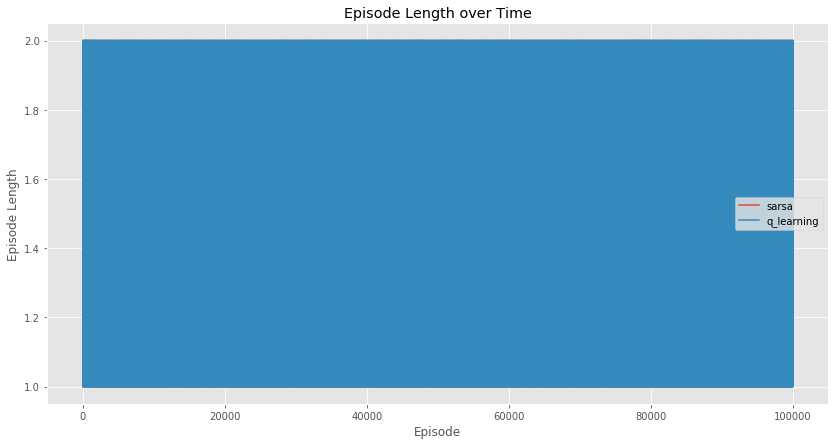

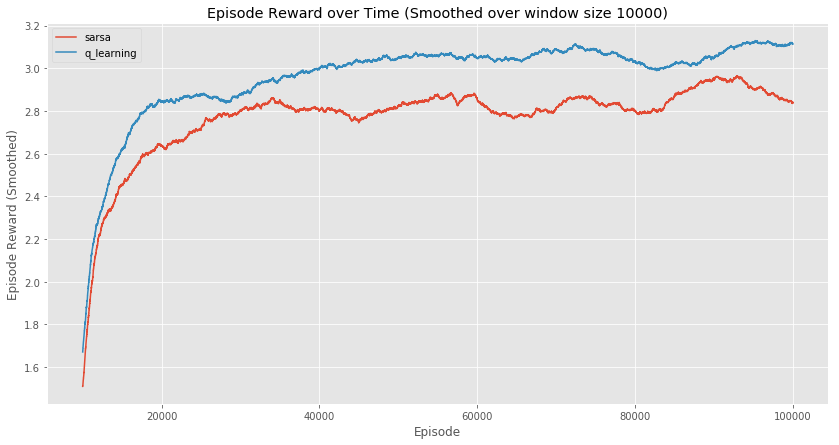

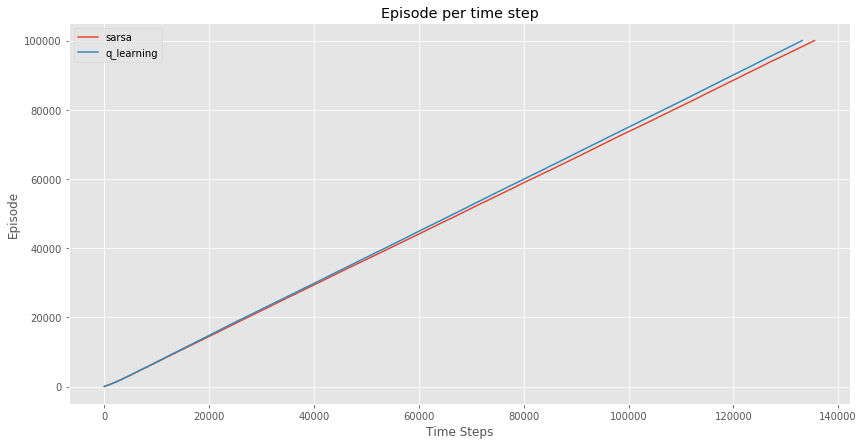

(<Figure size 1008x504 with 1 Axes>,
 <Figure size 1008x504 with 1 Axes>,
 <Figure size 1008x504 with 1 Axes>)

In [18]:
stats = [stats_sarsa, stats_qlearning]
labels = ['sarsa', 'q_learning']
plotting.plot_episode_stats_multiple_sets(stats, labels, smoothing_window = 10000)

In [10]:
import json
data = json.dumps(Q_sarsa)
f = open("Q_sarsa_10M_episodes.json","w")
f.write(data)
f.close()

In [ ]:
import json
data = json.dumps(Q_qlearning)
f = open("Q_qlearning_10M_episodes.json","w")
f.write(data)
f.close()

## Discussion

Theoretically Q learning should yield improvements over SARSA. Running the learning algorithm over 100,000 iterations takes SARSA 1 min 48 seconds compared to 1 min 28 seconds it takes for Q learning. Looking over the episode per timestep graph it appears that q_learning requires fewer time steps to complete each game but both algorithms are very close. The episode rewards appear to favor Q learning above 10,000 episodes. The reward structure influences how both approaches learn. Rewarding wins with +5, punishing losses awith -10, and penalizing every move with -1 might make the algorithms more defensive. Considering that only 255,168 tic tac toe games can be played there should always be a way for algorithm to draw any game and the rewards structure somewhat reflects that. In the limit of 100,000 episodes Q learning rewards the agent on average 0.2 units higher than SARSA. It appears in the environment setup favors Q learning as the superior learning algorithm.